# Lab 7: Error Mitigation in Deutsch--Josza
by Muhammad Faryad

In [1]:
from qiskit import QuantumCircuit, execute, Aer, BasicAer
from qiskit.visualization import plot_histogram

import numpy as np


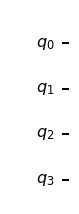

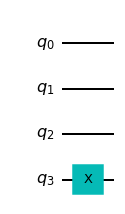

In [2]:
n=3
f0allx = QuantumCircuit(n+1) #constant oracle for f(x)=0 for all x


display(f0allx.draw('mpl'))

f1allx = QuantumCircuit(n+1) #constant oracle for f(x)=1 for all x
f1allx.x(n)

display(f1allx.draw('mpl'))

In [3]:

f01half = QuantumCircuit(n+1)
xgates = "100"
cxgates= "101"


# Put ancilia qubit in state |->
f01half.x(n)
f01half.h(n)

f01half.barrier()
# Place X-gates before implementing CX gates in the next loop
for i in range(n):
    if xgates[i] == '1':
        f01half.x(i)




# Place CX-gates to give phase at desired combinations
for m in range(n):
    if cxgates[m] == '1':
        f01half.cx(m,n)


# Place X-gates again to revert to original inputs on 0 to n-1 qubits
for k in range(n):
    if xgates[k] == '1':
        f01half.x(k)
f01half.barrier()
# Show oracle
f01half.draw()

░ ┌───┐     ┌───┐ ░ 
q_0: ───────────░─┤ X ├──■──┤ X ├─░─
                ░ └───┘  │  └───┘ ░ 
q_1: ───────────░────────┼────────░─
                ░        │        ░ 
q_2: ───────────░────────┼────■───░─
     ┌───┐┌───┐ ░      ┌─┴─┐┌─┴─┐ ░ 
q_3: ┤ X ├┤ H ├─░──────┤ X ├┤ X ├─░─
     └───┘└───┘ ░      └───┘└───┘ ░

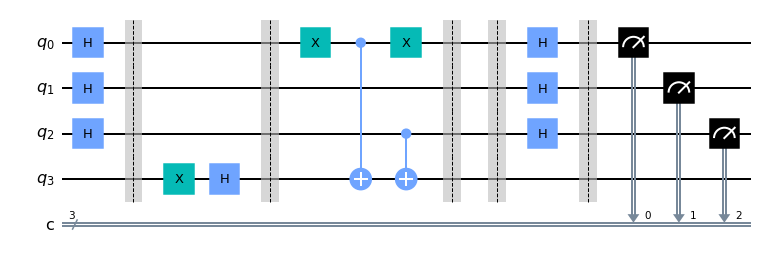

In [4]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)



dj_circuit.barrier()
# Add oracle
dj_circuit =dj_circuit + f01half
dj_circuit.barrier()
# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw('mpl')

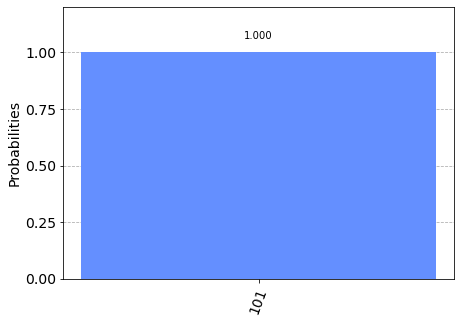

In [5]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(dj_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

In [7]:
from qiskit import IBMQ

IBMQ.save_account('b7c3d5261ffcdc9163d35371670119c46adb48436e35147c205928aa37c913fcbee976e715f8547f637f98adaff39dee787ff1b5038bac14d34fd69cd8937e28', overwrite=True)

In [8]:
provider=IBMQ.load_account()
backend=provider.get_backend('ibmq_quito')

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


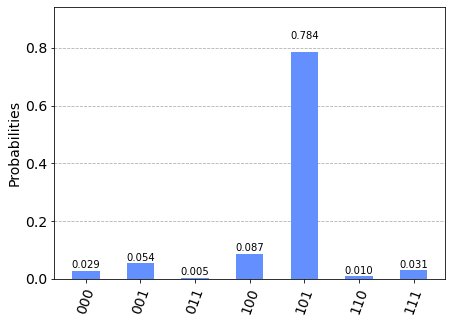

In [9]:
from qiskit import Aer, execute
noisy_results = execute(dj_circuit, backend=backend, shots=1000).result()
noisy_counts=noisy_results.get_counts()
from qiskit.visualization import plot_histogram
plot_histogram(noisy_counts)

In [10]:
from qiskit import QuantumRegister
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
# choose number of qubits in quantum registers according to your algo
qr = QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [11]:
from qiskit import QuantumCircuit, execute, Aer, BasicAer, transpile, assemble
t_qc = transpile(meas_calibs, backend)
cal_results =execute(t_qc,backend=backend, shots=1000).result()

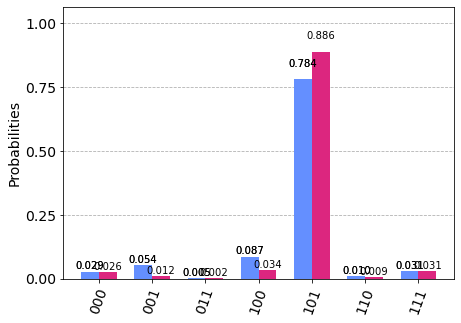

In [12]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(noisy_results)
mitigated_counts = mitigated_results.get_counts()
plot_histogram([noisy_counts,mitigated_counts])